In [2]:
import numpy as np
import pandas as pd

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils

import os

In [3]:
## Ne garder que les images câblées

liste_path_cablees=[]
dossier="D:/Documents/MINES/Info/projet_cern/ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("AfterBonding" in os.path.basename(fichier)):
        liste_path_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

liste_images_cablees=[plt.imread(image) for image in liste_path_cablees]


liste_path_non_cablees=[]
dossier="D:/Documents/MINES/Info/projet_cern/ModulePictures"

for fichier in os.listdir(dossier):
    if os.path.isfile(os.path.join(dossier, fichier)) and ("Reception" in os.path.basename(fichier)):
        liste_path_non_cablees.append(str(dossier + "/"+ os.path.basename(fichier)))

liste_images_non_cablees=[plt.imread(image) for image in liste_path_non_cablees]



In [4]:
## Fonctions utiles

def norme(pix):
    return np.sqrt((pix[0]/255)**2+(pix[1]/255)**2+(pix[2]/255)**2)

def tourner_image(image, pente):
    return imutils.rotate(image, np.arctan(pente))

def trouver_la_paire(fichier, dossier):
    bname=os.path.basename(fichier)
    if "After" in bname:
        name=bname[:bname.find("After")]
        for f in os.listdir(dossier):
            if "Reception" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("Reception")]==name:
                    return f
    elif "Reception" in bname:
        name=bname[:bname.find("Reception")]
        for f in os.listdir(dossier):
            if "After" in os.path.basename(f):
                if os.path.basename(f)[:os.path.basename(f).find("After")]==name:
                    return f
    return "Pas de paire"

In [5]:
trouver_la_paire("D:/Documents/MINES/Info/projet_cern/ModulePictures/P1011_20UPGM23210962_AfterWirebonding_NOK","D:/Documents/MINES/Info/projet_cern/ModulePictures")

'P1011_20UPGM23210962_Reception_Glo_NoLight.jpg'

---
## Trouver la colonne verte

### Sans binary : ça marche

In [21]:
## Trouver la colonne verte

def find_colonne(image):
    colonnes=[image[:,i,:] for i in range(image.shape[1])]
    i=0
    bool=False
    while not bool and i<len(colonnes)-1:
        col=colonnes[i]
        if (np.mean(col[:,0])+4<np.mean(col[:,1])) and (np.mean(col[:,2])+4<np.mean(col[:,1])):
            bool=True
        if not bool:
            i+=1
    return i, colonnes[i]


In [60]:
## Trouver la colonne verte v2

def find_colonne_v2(image):
    colonnes=[image[:,i,:] for i in range(image.shape[1])]
    i=0
    bool=False
    while not bool and i<len(colonnes)-1:
        col=colonnes[i]
        cpt=0
        for pix in col:
            if (40<pix[0]<100) and (40<pix[1]<100) and  (pix[2]<20):
                cpt+=1       
        if cpt>0.1*image.shape[1]:
            bool=True
        if not bool:
            i+=1
    return i, colonnes[i]


In [ ]:
## Test

for i,im in enumerate(liste_images_cablees):
    print(f"Colonne {find_colonne_v2(im)[0]}")
    plt.scatter(find_colonne_v2(im)[0], 0, color='tab:red', marker='+', s=300)
    plt.title(f'Image {i}')
    plt.imshow(im)
    plt.show()

### Avec binary : ça marche pas 

In [8]:
def binariser_image (path):
    image=cv.imread(path, cv.IMREAD_GRAYSCALE)
    return cv.threshold(image, 127, 255, cv.THRESH_BINARY)[1]

image = binariser_image(liste_path_cablees[0]) 

screen_res = 1280, 720
scale_width = screen_res[0] / image.shape[1]
scale_height = screen_res[1] / image.shape[0]
scale = min(scale_width, scale_height)
window_width = int(image.shape[1] * scale)
window_height = int(image.shape[0] * scale)

cv.namedWindow('apagnan', cv.WINDOW_NORMAL)
cv.resizeWindow('apagnan', window_width, window_height)
cv.imshow('apagnan', image )
cv.waitKey(0)
cv.destroyAllWindows()

In [9]:
def find_colonne_binary(path):
    bin= binariser_image(path)
    colonnes=[bin[:,i] for i in range(bin.shape[1])]
    i=0
    bool=False
    while not bool and i<len(colonnes):
        col=colonnes[i]
        if np.mean(col) < 240:
            bool=True
        if not bool:
            i+=1
    return i, colonnes[i]

Colonne 221


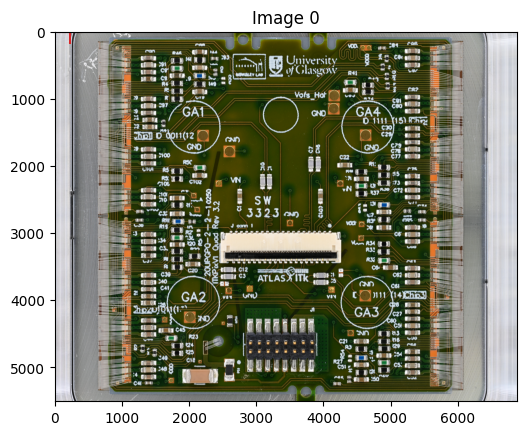

Colonne 291


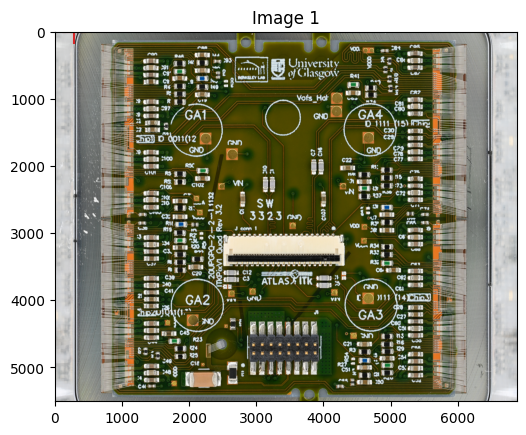

Colonne 139


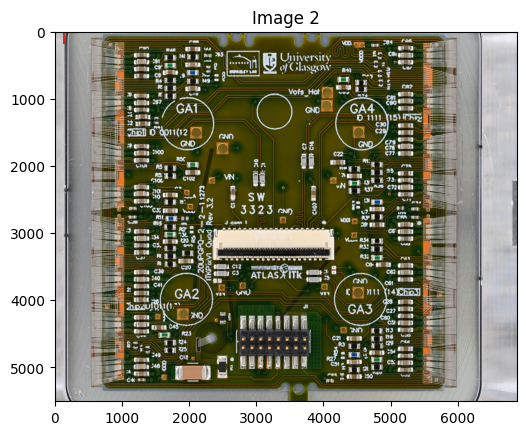

In [10]:
# Test 

for i,pth in enumerate(liste_path_cablees[:3]):
    print(f"Colonne {find_colonne_binary(pth)[0]}")
    plt.imshow(plt.imread(pth))
    plt.scatter(find_colonne_binary(pth)[0], 0, color='tab:red', marker='+', s=300)
    plt.title(f'Image {i}')
    plt.show()

---
## Détection de cercles et de contours

In [11]:
## Récupérer les carrés contenant la mire 

def carre_mire(image):
    col=find_colonne(image)[0]
    return image[200:500,250:550,:]

In [12]:
##  Détection de cercles

for path in liste_path_non_cablees[:2] :
    #Lecture de l'image en noir et blanc
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    assert img is not None, "file could not be read, check with os.path.exists()"

    ## TODO : changer cette extraction à la main par quelque chose d'automatisé
    img = img[100:400,300:600]

    #Blur pour réduire le bruit
    img = cv.medianBlur(img,5)
    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

    #FOnction qui détecte les cercles. minDist = 1e5 pour s'assurer qu'il n'en détecte qu'un => il ne faut qu'un cercle sur l'image.
    circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,minDist = 1e5,
                                param1=50,param2=20,minRadius=20,maxRadius=30)

    #Dessin des cercles
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        cv.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

    cv.imshow('detected circles',cimg)
    cv.waitKey(0)
    cv.destroyAllWindows()

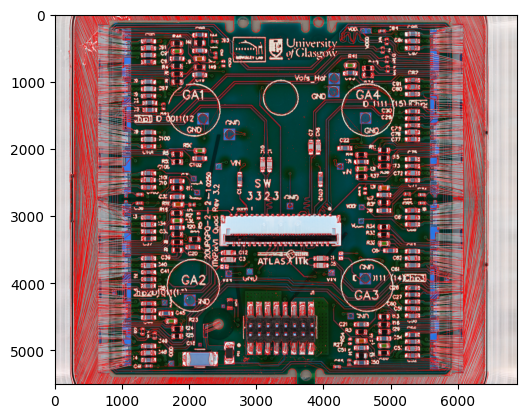

In [13]:
# Charger l'image
i=0
image_lue=liste_images_cablees[i]
col=find_colonne(image_lue)[0]
path=liste_path_cablees[i]

image=cv.imread(path)
#gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Appliquer un flou pour réduire le bruit
blurred = cv.GaussianBlur(image, (5, 5), 0)

# Détecter les contours avec Canny
edges = cv.Canny(blurred, 50, 150)

# Trouver les contours
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

for contour in contours:
    # Approximation des contours pour simplifier les formes
    epsilon = 0.02 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, epsilon, True)

    # Dessiner les contours détectés
    cv.drawContours(blurred, [approx], -1, (255, 0, 0), 2)

    # Identifier les formes en fonction du nombre de sommets
    if len(approx) == 4:
        # Vérifier si c'est un carré ou un rectangle
        x, y, w, h = cv.boundingRect(approx)

    # Ajouter le nom de la forme sur l'image
    x, y = approx[0][0]
# Afficher l'image avec les formes détectées
plt.imshow(blurred)
plt.show()

In [14]:
img = cv.imread(liste_path_cablees[5])

lower_bound = np.array([0, 0, 0])
upper_bound = np.array([255,70,70])
imagemask = cv.inRange(img, lower_bound, upper_bound)
imagemask = cv.medianBlur(imagemask,9)

# Trouver les contours
contours, _ = cv.findContours(imagemask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Parcourir les contours pour détecter les carrés
for contour in contours:
    # Approximation du contour
    epsilon = 0.02 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, epsilon, True)

    # Vérifier si c'est un carré (4 côtés et une aire significative)
    if len(approx) == 4 :
        # Vérifier si les côtés sont à peu près égaux
        (x, y, w, h) = cv.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.9 <= aspect_ratio <= 1.1:  # Aspect ratio proche de 1 pour un carré
            # Dessiner le contour du carré
            cv.drawContours(img, [approx], -1, (0, 255, 0), 10)


screen_res = 1280, 720
scale_width = screen_res[0] / img.shape[1]
scale_height = screen_res[1] / img.shape[0]
scale = min(scale_width, scale_height)
window_width = int(img.shape[1] * scale)
window_height = int(img.shape[0] * scale)

cv.namedWindow('title', cv.WINDOW_NORMAL)
cv.resizeWindow('title', window_width, window_height)
cv.imshow('title',img)
cv.waitKey(0)
cv.destroyAllWindows()

---
## Inutile

Colonne 796


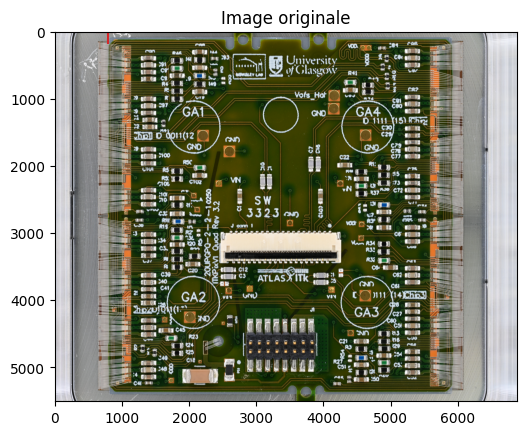

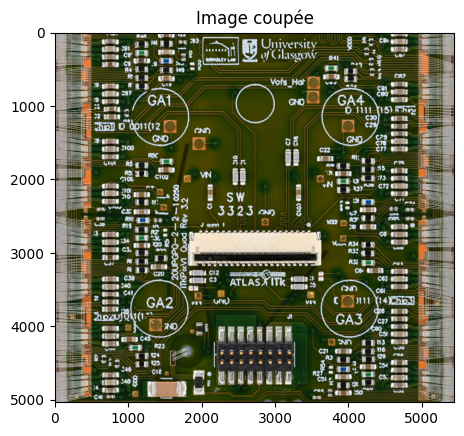

In [15]:
img = cv.imread(liste_path_cablees[0], cv.IMREAD_GRAYSCALE)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

# Slicing manuel : à changer si possible
dec_g=1000
dec_d=-1000
dec_h=500
dec_b=-500
mask = cv.medianBlur(img[dec_h:dec_b,dec_g:dec_d],25)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

#Fonction qui détecte les cercles.
circles = cv.HoughCircles(mask,cv.HOUGH_GRADIENT,1,minDist = 800,
            param1=50,param2=25,minRadius=400 ,maxRadius=420)

circles = np.uint16(np.around(circles))
for i in circles[0,:4]:
    # draw the outer circle
    #cv.circle(cimg,(i[0]+1000,i[1]+500),i[2],(0,255,0),200)
    # draw the center of the circle
    cv.circle(img,(i[0]+1000,i[1]+500),2,(255,0,0),100)

img=liste_images_cablees[0]
print(f"Colonne {find_colonne(img)[0]}")
plt.imshow(img)
plt.scatter(int(find_colonne(img)[0]), 0, color='tab:red', marker='+', s=300)
plt.title('Image originale')
plt.show()

cercles_haut=[]
cercles_bas=[]
for cercle in circles[0,:4]:
    if cercle[1]>cimg.shape[0]/2:
        cercles_bas.append(cercle)
    else:
        cercles_haut.append(cercle)

cercles_haut = sorted(cercles_haut, key=lambda x: x[0])
cercles_bas = sorted(cercles_bas, key=lambda x: x[0])
c1,c2=cercles_haut
c3,c4=cercles_bas
x_g_m=int(0.5*(c1[0]+c3[0]))
x_d_m=int(0.5*(c2[0]+c4[0]))
y_h_m=int(0.5*(c1[1]+c2[1]))
y_b_m=int(0.5*(c3[1]+c4[1]))
image_coupee=img[(y_h_m-dec_h-150):(y_b_m-dec_b+1280),x_g_m-400:(x_d_m-dec_d+1420),:]

cv.imshow('tkt',image_coupee)
cv.waitKey(0)
cv.destroyAllWindows()

plt.imshow(image_coupee)
plt.title('Image coupée')
plt.show()


---
## Test de tout assemblé

In [16]:
def slope_pcb(img) :

    lower_bound = np.array([0, 40, 0])
    upper_bound = np.array([40,110,110])
    bwimg = cv.inRange(img, lower_bound, upper_bound)
    imagemask_green = cv.medianBlur(bwimg,25)

    middle = img.shape[1]//2

    cimg2 = cv.cvtColor(imagemask_green,cv.COLOR_GRAY2BGR)

    top_contour = np.zeros((1000,2),dtype=np.int32)
    bot_contour = np.zeros((1000,2),dtype=np.int32)

    for j in range(middle - 2000, middle - 1000, 2) :

        top_contour[(j - middle + 2000)//2] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle + 2000)//2] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    for j in range(middle + 1000, middle + 2000, 2) : 

        top_contour[(j - middle)//2] = [j,min(np.where(imagemask_green[:,j] == 255)[0])]
        bot_contour[(j - middle)//2] = [j,max(np.where(imagemask_green[:,j] == 255)[0])]

    slope = 0.5*(stats.linregress(top_contour[:,0], top_contour[:,1]).slope + stats.linregress(bot_contour[:,0], bot_contour[:,1]).slope)

    return slope